In [1]:
import pandas as pd
import rasa
import os

In [2]:
BASE_PATH = "."

In [3]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:  
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = "/content/drive/MyDrive/NLP/CA6"

In [4]:
TRAIN_PATH = os.path.join(BASE_PATH, "Data/MCI_Internet_TrainData.xlsx")
TEST_PATH = os.path.join(BASE_PATH, "Data/MCI_Internet_TestData.xlsx")
RASA_PATH = os.path.join(BASE_PATH, "rasa")
RASA_DATA_PATH = os.path.join(RASA_PATH, "data")
RASA_TEST_PATH = os.path.join(RASA_PATH,"test_nlu")

In [5]:
# Read xlsx file into a pandas dataframe
train_df = pd.read_excel(TRAIN_PATH)
test_df = pd.read_excel(TEST_PATH)


In [6]:
train_df.head(2)

,شناسه,پاسخ,سطح ۱,سطح ۲,سطح ۳,سطح ۴,سطح ۵,پرسش ۱,پرسش ۲,پرسش ۳,...,پرسش ۶,پرسش ۷,پرسش ۸,پرسش ۹,پرسش ۱۰,پرسش ۱۱,پرسش ۱۲,پرسش ۱۳,پرسش ۱۴,پرسش ۱۵
0,1,مشترک گرامی جهت فعالسازی سرویس اینترنت (GPRS) ...,اینترنت,مشکلات,فعال سازی سرویس,NaN,NaN,برای فعال سازی سرویس gprs با استفاده از کد دس...,برای فعالسازی سرویس gprs چه شماره ای باید بگیرم؟,برای فعالسازی سرویس gprs چه کدی رو باید بزنم؟,...,چه کدی برای فعالسازی سرویس اینترنت gprs باید ...,gprs رو با استفاده از کد دستوری چجوری فعال کنم؟,سرویس اینترنت فعال سازیش با استفاده از کد دستو...,کد فعالسازی سرویس اینترنت چیه؟,چیکار باید بکنم تا سرویس اینترنتم با استفاده ا...,میخوام سرویس اینترنت gprs فعال بشه با استفاده ...,سرویس اینترنتم چی جوری با استفاده از کد دستوری...,واسه فعال شدن سرویس اینترنتم با کد دستوری چیکا...,برای فعال شدن سرویس اینترنت چه کدی رو باید بگیرم؟,برای فعال شدن اینترنت gprs با استفاده از کد دس...
1,2,مشترک گرامی جهت فعالسازی سرویس اینترنت (GPRS) ...,اینترنت,مشکلات,فعال سازی سرویس,NaN,NaN,برای فعالسازی سرویس gprs از طریق پیامک چیکار کنم؟,برای فعال سازی سرویس gprs به چه شماره ای باید ...,برای فعالسازی سرویس gprs به چه شماره ای باید ا...,...,به چه شماره ای برای فعالسازی سرویس اینترنت gpr...,gprs رو از طریق پیامک چجوری فعال کنم؟,سرویس اینترنت فعال سازیش از طریق پیامک Sms چجو...,sms فعال سازی سرویس اینترنت چیه؟,به چه شماره ای پیامک اس ام اس sms بدم تا سرویس...,میخوام سرویس اینترنت gprs فعال بشه از طریق پیا...,سرویس اینترنتم از طریق پیامک چیجوری فعال میشه؟,واسه فعال شدن سرویس اینترنتم از طریق پیامک اس ...,برای فعال شدن سرویس اینترنت چه اس ام اسی باید ...,برای فعال شدن اینترنت gprs از طریق پیامک کاری...


Translate DF Intents to English

In [7]:

# Translate columns from index 2 to 4 to english
translation_dict = {
    "اینترنت": "Internet",
    "مشکلات": "Problems",
    "بسته": "Package",
    "فعال سازی سرویس": "Service Activation",
    "غیر فعال سازی سرویس": "Service Deactivation",
    "سرویس آموزش": "Educational Service",
    "مشکلات اتصال به اینترنت": "Internet Connection Problems",
    "4G و 4.5G": "4G and 4.5G",
    "خرید بسته از شاپ (فروشگاه)": "Package Purchase from Shop",
    "خرید بسته از *100#": "Package Purchase from *100#",
    "نام تجاری نوترینو": "Notrino Brand",
    "بسته‌های اینترنت پاک": "Pocket Internet Packages",
    "بسته‌های ساعات مشخص": "Specific Hour Packages",
    "بسته ویژه مشترکین جدید": "Special Package for New Subscribers",
    "استعلام بسته": "Package Inquiry",
    "لغو تمدید بسته": "Package Renewal Cancellation",
    "بسته‌های نامحدود شبانه": "Unlimited Night Packages",
    "بسته‌های اینترنت": "Internet Packages",
}


Utility Functions for Pipeline

In [8]:
intent_cols = ["سطح ۱", "سطح ۲" , "سطح ۳"]

def preprocess_df(df,translate=True):
    # Delete Extra Cols

    deleted_cols = ["سطح ۴","سطح ۵"]
    df.drop(deleted_cols, axis=1, inplace=True)

    if translate:
        # Search only  in the columns from index 2 to 4 and replace the persian words with english words
        df.iloc[:, 2:5] = df.iloc[:, 2:5].replace(translation_dict)


    # Replace all spaces in columns from index 2 to 4 with underscore
    df.iloc[:, 2:5] = df.iloc[:, 2:5].replace(" ", "_", regex=True)
    
    # Replace all line breaks in second column of train_df with triple space
    df.iloc[:, 1] = df.iloc[:, 1].str.replace("\n", "   ", regex=True)

    return df

def generate_intents(df,intent_cols=intent_cols):
   # For Each row in train_df, concatenate the columns of intent_cols, and append them intents list. then scan the intents list and if you see any duplicates, prefix them with numbers

    intents = []
    for index, row in df.iterrows():
        intent = ""
        for col in intent_cols:
            intent += f"{row[col]}_"
        intents.append(intent)
    return intents

def generate_intent_groups(intents):
    # Break intents list into the sub-lists of duplicate items, for example [x,y,y,x,z] will become [x,x] , [y,y] , [z]

    intent_groups = {}
    for intent in intents:
        if intent in intent_groups.keys():
            intent_groups[intent].append(f"{intent}_{len(intent_groups[intent])+1}")
        else:
            intent_groups[intent] = [f"{intent}_1"]

    return intent_groups


def generate_intent_joined(df): 
    # for each row of train_df, make a column called intent_main which is intent += f"{row[col]}_" for all col in intent_cols

    df["intent_main"] = ""
    for index, row in df.iterrows():
        intent = ""
        for col in intent_cols:
            intent += f"{row[col]}_"
        df.loc[index, "intent_main"] = intent
    return df

def generate_intent_joined_postfixed(df,intent_groups):
    # Postfix the same intents with numbers
    df["intent_postfixed"] = ""

    intent_count_tmp = {}
    for index,row in df.iterrows():
        intent = row["intent_main"]
        intent_postfixed = ""
        if intent in intent_groups.keys():
            if intent not in intent_count_tmp.keys():
                intent_count_tmp[intent] = 0
                intent_postfixed = intent_groups[intent][0]
            else:
                intent_count_tmp[intent] += 1
                intent_postfixed = intent_groups[intent][intent_count_tmp[intent]]
        df.loc[index, "intent_postfixed"] = intent_postfixed
    # make the intent_postfixed column lowercased
    df["intent_postfixed"] = df["intent_postfixed"].str.lower()

    return df


In [9]:
def rasa_data_pipeline(df):
    
    df = preprocess_df(df)
    intents = generate_intents(df)
    intent_groups = generate_intent_groups(intents)
    df_with_intents_joined = generate_intent_joined(df)
    df_with_intents_postfixed = generate_intent_joined_postfixed(df,intent_groups)

    return intents,intent_groups,df_with_intents_postfixed
 

In [10]:
_ , _ , train_df = rasa_data_pipeline(train_df)
_ , _ , test_df = rasa_data_pipeline(test_df)

In [11]:
train_df.head(2)

,شناسه,پاسخ,سطح ۱,سطح ۲,سطح ۳,پرسش ۱,پرسش ۲,پرسش ۳,پرسش ۴,پرسش ۵,...,پرسش ۸,پرسش ۹,پرسش ۱۰,پرسش ۱۱,پرسش ۱۲,پرسش ۱۳,پرسش ۱۴,پرسش ۱۵,intent_main,intent_postfixed
0,1,مشترک گرامی جهت فعالسازی سرویس اینترنت (GPRS) ...,Internet,Problems,Service_Activation,برای فعال سازی سرویس gprs با استفاده از کد دس...,برای فعالسازی سرویس gprs چه شماره ای باید بگیرم؟,برای فعالسازی سرویس gprs چه کدی رو باید بزنم؟,چجوری سرویس اینترنت gprs با استفاده از کد دستو...,چه شماره ای برای فعالسازی سرویس اینترنت gprs ب...,...,سرویس اینترنت فعال سازیش با استفاده از کد دستو...,کد فعالسازی سرویس اینترنت چیه؟,چیکار باید بکنم تا سرویس اینترنتم با استفاده ا...,میخوام سرویس اینترنت gprs فعال بشه با استفاده ...,سرویس اینترنتم چی جوری با استفاده از کد دستوری...,واسه فعال شدن سرویس اینترنتم با کد دستوری چیکا...,برای فعال شدن سرویس اینترنت چه کدی رو باید بگیرم؟,برای فعال شدن اینترنت gprs با استفاده از کد دس...,Internet_Problems_Service_Activation_,internet_problems_service_activation__1
1,2,مشترک گرامی جهت فعالسازی سرویس اینترنت (GPRS) ...,Internet,Problems,Service_Activation,برای فعالسازی سرویس gprs از طریق پیامک چیکار کنم؟,برای فعال سازی سرویس gprs به چه شماره ای باید ...,برای فعالسازی سرویس gprs به چه شماره ای باید ا...,چجوری سرویس اینترنت gprs از طریق پیامک اس ام ا...,به کجا برای فعال سازی سرویس اینترنت gprs باید ...,...,سرویس اینترنت فعال سازیش از طریق پیامک Sms چجو...,sms فعال سازی سرویس اینترنت چیه؟,به چه شماره ای پیامک اس ام اس sms بدم تا سرویس...,میخوام سرویس اینترنت gprs فعال بشه از طریق پیا...,سرویس اینترنتم از طریق پیامک چیجوری فعال میشه؟,واسه فعال شدن سرویس اینترنتم از طریق پیامک اس ...,برای فعال شدن سرویس اینترنت چه اس ام اسی باید ...,برای فعال شدن اینترنت gprs از طریق پیامک کاری...,Internet_Problems_Service_Activation_,internet_problems_service_activation__2


In [12]:
test_df.head(2)

,شناسه,پاسخ,سطح ۱,سطح ۲,سطح ۳,پرسش ۱,پرسش ۲,پرسش ۳,پرسش ۴,پرسش ۵,intent_main,intent_postfixed
0,1,مشترک گرامی جهت فعالسازی سرویس اینترنت (GPRS) ...,Internet,Problems,Service_Activation,سرویس اینترنتی با استفاده از کد دستوری چجوری ف...,چجوری سرویس اینترنت با استفاده از کد دستوری فع...,سرویس اینترنتم نیاز به فعالسازی داره؟ کد دستور...,چجوری سرویس اینترنتم رو با استفاده از کد دستور...,فعال شدن سرویس اینترنت چجوریه؟,Internet_Problems_Service_Activation_,internet_problems_service_activation__1
1,2,مشترک گرامی جهت فعالسازی سرویس اینترنت (GPRS) ...,Internet,Problems,Service_Activation,سرویس اینترنتی چجوری از طریق پیامک فعال میشه؟,چجوری سرویس اینترنت از طریق اس ام اس فعال میشه؟,سرویس اینترنتم نیاز به فعالسازی داره؟ از طریق ...,چجوری سرویس اینترنتم رو از طریق پیامک sms فعال...,فعال شدن سرویس اینترنت از طریق پیامک چجوریه؟,Internet_Problems_Service_Activation_,internet_problems_service_activation__2


In [13]:
# Sort the dataframe by intent_postfixed column
train_df.sort_values(by=["intent_postfixed"], inplace=True)

In [14]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   شناسه             50 non-null     int64 
 1   پاسخ              50 non-null     object
 2   سطح ۱             50 non-null     object
 3   سطح ۲             50 non-null     object
 4   سطح ۳             50 non-null     object
 5   پرسش ۱            50 non-null     object
 6   پرسش ۲            50 non-null     object
 7   پرسش ۳            50 non-null     object
 8   پرسش ۴            50 non-null     object
 9   پرسش ۵            50 non-null     object
 10  intent_main       50 non-null     object
 11  intent_postfixed  50 non-null     object
dtypes: int64(1), object(11)
memory usage: 4.8+ KB


In [15]:
test_df.head(2)

,شناسه,پاسخ,سطح ۱,سطح ۲,سطح ۳,پرسش ۱,پرسش ۲,پرسش ۳,پرسش ۴,پرسش ۵,intent_main,intent_postfixed
0,1,مشترک گرامی جهت فعالسازی سرویس اینترنت (GPRS) ...,Internet,Problems,Service_Activation,سرویس اینترنتی با استفاده از کد دستوری چجوری ف...,چجوری سرویس اینترنت با استفاده از کد دستوری فع...,سرویس اینترنتم نیاز به فعالسازی داره؟ کد دستور...,چجوری سرویس اینترنتم رو با استفاده از کد دستور...,فعال شدن سرویس اینترنت چجوریه؟,Internet_Problems_Service_Activation_,internet_problems_service_activation__1
1,2,مشترک گرامی جهت فعالسازی سرویس اینترنت (GPRS) ...,Internet,Problems,Service_Activation,سرویس اینترنتی چجوری از طریق پیامک فعال میشه؟,چجوری سرویس اینترنت از طریق اس ام اس فعال میشه؟,سرویس اینترنتم نیاز به فعالسازی داره؟ از طریق ...,چجوری سرویس اینترنتم رو از طریق پیامک sms فعال...,فعال شدن سرویس اینترنت از طریق پیامک چجوریه؟,Internet_Problems_Service_Activation_,internet_problems_service_activation__2


In [16]:
# Delete nlu.yml file if exists
# Write intents and examples in rasa.yml format, intent in each row is the intent_postfixed column of train_df and examples are columns from index 2 to 19

def write_nlu_file(df,tgt_path,responses_range):
    if os.path.exists(tgt_path):
        os.remove(tgt_path)

    with open(tgt_path, "a") as f:
        f.write("version: \"3.1\"\n\n")
        f.write(f"nlu: \n")        
        for index, row in df.iterrows():
            f.write(f"-  intent:  faq/{row['intent_postfixed']}\n")
            f.write(f"   examples:  |\n")
            for i in range(responses_range[0],responses_range[1]):
                if not pd.isna(row[i]):
                    f.write(f"    - {row[i]}\n")


In [17]:
train_tgt_path = os.path.join(RASA_DATA_PATH, "nlu.yml")
test_tgt_path = os.path.join(RASA_TEST_PATH, "test.yml")
train_resp_range = (5,20)
test_resp_range = (5,10)
write_nlu_file(train_df, train_tgt_path,train_resp_range)
write_nlu_file(test_df,test_tgt_path,test_resp_range)

In [18]:
# Delete responses.yml file if exists
# Write responses in rasa.yml format, intent in each row is the intent_postfixed column of response is the column with the index of 1
def write_domain_file(df,tgt_path):

    if os.path.exists(tgt_path):
        os.remove(tgt_path)

    with open(tgt_path, "a") as f:
        f.write("version: \"3.1\"\n\n")
        f.write("intents:\n")
        f.write("  - faq\n\n")
        f.write(f"responses: \n")        
        for index, row in train_df.iterrows():
            f.write(f"  utter_faq/{row['intent_postfixed']}:\n")
            f.write(f"  - text:  |\n")
            f.write(f"      {row[1]}\n")
        f.write("session_config:\n")
        f.write("  session_expiration_time: 60\n")
        f.write("  carry_over_slots_to_new_session: true\n")

domain_tgt_path = os.path.join(RASA_PATH, "domain.yml")
write_domain_file(train_df,domain_tgt_path)

# Multi Intent

In [19]:
RASA_PATH = os.path.join(BASE_PATH, "rasa_multi_intent")
RASA_DATA_PATH = os.path.join(RASA_PATH, "data")
RASA_TEST_PATH = os.path.join(RASA_PATH,"test_nlu")

In [20]:
# Delete nlu.yml file if exists
# Write intents and examples in rasa.yml format, intent in each row is the intent_postfixed column of train_df and examples are columns from index 2 to 19


def write_nlu_file(df,tgt_path,responses_range):
    if os.path.exists(tgt_path):
        os.remove(tgt_path)

    with open(tgt_path, "a") as f:
        f.write("version: \"3.1\"\n\n")
        f.write(f"nlu: \n")        
        for index, row in df.iterrows():
            f.write(f"-  intent:  {row['intent_postfixed']}\n")
            f.write(f"   examples:  |\n")
            for i in range(responses_range[0],responses_range[1]):
                if not pd.isna(row[i]):
                    f.write(f"    - {row[i]}\n")


In [21]:
train_tgt_path = os.path.join(RASA_DATA_PATH, "nlu.yml")
test_tgt_path = os.path.join(RASA_TEST_PATH, "test.yml")
train_resp_range = (5,20)
test_resp_range = (5,10)
write_nlu_file(train_df, train_tgt_path,train_resp_range)
write_nlu_file(test_df,test_tgt_path,test_resp_range)

In [22]:
def write_domain_file_multi(df,tgt_path):

    if os.path.exists(tgt_path):
        os.remove(tgt_path)

    with open(tgt_path, "a") as f:
        f.write("version: \"3.1\"\n\n")
        f.write("intents:\n")
        for intent in df["intent_postfixed"]:
            f.write(f"  -  {intent}\n")
        f.write(f"responses: \n")        
        for index, row in train_df.iterrows():
            f.write(f"  utter_{row['intent_postfixed']}:\n")
            f.write(f"  - text:  |\n")
            f.write(f"      {row[1]}\n")
        f.write("session_config:\n")
        f.write("  session_expiration_time: 60\n")
        f.write("  carry_over_slots_to_new_session: true\n")

domain_tgt_path = os.path.join(RASA_PATH, "domain.yml")
write_domain_file_multi(train_df,domain_tgt_path)

In [30]:
tgt_path = os.path.join(RASA_DATA_PATH,"rules.yml")

def generate_rules(df,tgt_path):
    if os.path.exists(tgt_path):
        os.remove(tgt_path)
    
    with open(tgt_path,"a") as f:
        f.write("version: \"3.1\" \n\n\n")
        f.write("rules: \n")
        for intent in df["intent_postfixed"]:
            f.write(f"- rule: respond to {intent} \n ")
            f.write(f" steps: \n")
            f.write(f"  - intent: {intent} \n")
            f.write(f"  - action: utter_{intent} \n")
        
generate_rules(train_df,tgt_path)

In [ ]:
/home/vavre/nlp/nlp-ut/CA6/rasa/ParsBert_100/response_selection_report.json

In [62]:
# read json file of the path ./rasa/ParsBert_100/response_selection_report.json
import json 

with open("./rasa/ParsBert_100/response_selection_report.json") as f:
    rasa_parsbert_100 = json.load(f)

with open("./rasa/LabSE_100/response_selection_report.json") as f:
    rasa_labse_100 = json.load(f)

with open("./rasa/LaBSE_200/response_selection_report.json") as f:
    rasa_labse_200 = json.load(f)

with open("./rasa/LaBSE_50/response_selection_report.json") as f:
    rasa_labse_50 = json.load(f)


In [63]:
# plot accuracy in rasa_parsbert_100 and rasa_labse_100 in a line chart using seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# take the accuracy, macro avg, weighted avg from rasa_parsbert_100 and rasa_labse_100 and put them in a dataframe

rasa_parsbert_100 = pd.DataFrame(rasa_parsbert_100)
rasa_labse_100 = pd.DataFrame(rasa_labse_100)
rasa_labse_200 = pd.DataFrame(rasa_labse_200)
rasa_labse_50 = pd.DataFrame(rasa_labse_50)

rasa_labse_100

,faq/internet_package_special_package_for_new_subscribers__3,faq/internet_problems_educational_service__1,faq/internet_package_special_package_for_new_subscribers__1,faq/internet_package_unlimited_night_packages__3,faq/internet_problems_service_activation__2,faq/internet_problems_internet_connection_problems__5,faq/internet_problems_service_deactivation__2,faq/internet_problems_service_activation__1,faq/internet_package_notrino_brand__1,faq/internet_package_package_renewal_cancellation__2,...,faq/internet_package_package_renewal_cancellation__3,faq/internet_problems_internet_connection_problems__1,faq/internet_package_package_purchase_from_shop__2,faq/internet_problems_internet_connection_problems__6,faq/internet_package_notrino_brand__2,faq/internet_package_package_renewal_cancellation__5,accuracy,macro avg,weighted avg,micro avg
precision,1.0,1.0,1.0,0.833333,0.833333,1.0,1.0,1.0,1.0,1.0,...,0.6,0.833333,1.0,0.833333,0.833333,1.0,0.892,0.898000,0.898000,0.892
recall,0.8,1.0,1.0,1.0,1.0,1.0,1.0,0.8,1.0,1.0,...,0.6,1.0,1.0,1.0,1.0,1.0,0.892,0.892000,0.892000,0.892
f1-score,0.888889,1.0,1.0,0.909091,0.909091,1.0,1.0,0.888889,1.0,1.0,...,0.6,0.909091,1.0,0.909091,0.909091,1.0,0.892,0.889364,0.889364,0.892
support,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,0.892,250.000000,250.000000,250.000
confused_with,{'faq/internet_package_specific_hour_packages_...,{},{},{},{},{},{},{'faq/internet_problems_service_activation__2'...,{},{},...,{'faq/internet_package_package_renewal_cancell...,{},{},{},{},{},0.892,NaN,NaN,NaN


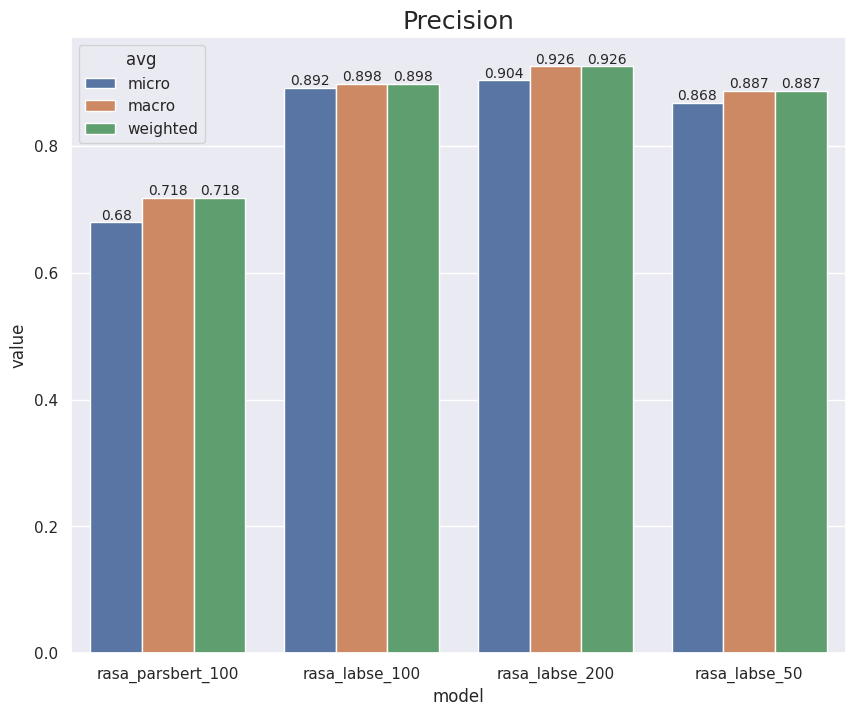

In [73]:
# Plot 3 stacked bar chart for precision, recall and f1-score, in x axis each stack is a model like parsbert_100 and labse_100, each stack has three bars which are the value of precision, recall and f1-score for micro avg, macro avg and weighted avg



prec_data = {
    "model":["rasa_parsbert_100","rasa_labse_100","rasa_labse_200","rasa_labse_50"],
    "micro":[rasa_parsbert_100["micro avg"]["precision"],rasa_labse_100["micro avg"]["precision"],rasa_labse_200["micro avg"]["precision"],rasa_labse_50["micro avg"]["precision"]],
    "macro":[rasa_parsbert_100["macro avg"]["precision"],rasa_labse_100["macro avg"]["precision"],rasa_labse_200["macro avg"]["precision"],rasa_labse_50["macro avg"]["precision"]],
    "weighted":[rasa_parsbert_100["weighted avg"]["precision"],rasa_labse_100["weighted avg"]["precision"],rasa_labse_200["weighted avg"]["precision"],rasa_labse_50["weighted avg"]["precision"]]
}

# round all numbers in prec_data to 2 decimal places
for key in prec_data.keys():
    if key != "model":
        prec_data[key] = [round(num,3) for num in prec_data[key]]


prec_df = pd.DataFrame(prec_data)
prec_df = prec_df.melt(id_vars="model",var_name="avg",value_name="value")

sns.set_style("whitegrid")
sns.set_palette("husl")
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.barplot(x="model",y="value",hue="avg",data=prec_df)

# Add value labels to each bar
for p in ax.containers:
    ax.bar_label(p, label_type='edge', fontsize=10)

# Add Precision title to the plot
plt.title("Precision",fontsize=18)

plt.show()


